<a href="https://colab.research.google.com/github/Tsunami-Song/DSDNE/blob/main/experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from __future__ import print_function, division
import numpy as np 
import pandas as pd 

import os
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

edges = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

In [3]:
data = pd.read_csv(r"/content/drive/MyDrive/SDNE/sdne_feature_e500_b9.txt")
orig2contiguos = pd.read_csv(r"/content/drive/MyDrive/AML/EvolveGCN-master/elliptic_bitcoin_dataset/elliptic_txs_orig2contiguos.csv")
orig2contiguos.columns=["originalId","txId"]
new_sdne_feature = pd.merge(orig2contiguos,data,on='txId')
new_sdne_feature = new_sdne_feature.drop('txId',axis=1)
sdne_feature_col = ["emb_feature_"+str(i) for i in range(1,65)]
new_sdne_feature.columns=["txId"]+sdne_feature_col
sdne_feature_names = ["emb_feature_"+str(i) for i in range(1,65)]

data_pro = pd.read_csv(r"/content/drive/MyDrive/SDNE/dsdne_feature_e500_b9.txt")
orig2contiguos = pd.read_csv(r"/content/drive/MyDrive/AML/EvolveGCN-master/elliptic_bitcoin_dataset/elliptic_txs_orig2contiguos.csv")
orig2contiguos.columns=["originalId","txId"]
new_sdne_feature_pro = pd.merge(orig2contiguos,data_pro,on='txId')
new_sdne_feature_pro = new_sdne_feature_pro.drop('txId',axis=1)
sdne_feature_col = ["emb_feature_"+str(i) for i in range(1,65)]
new_sdne_feature_pro.columns=["txId"]+sdne_feature_col
sdne_feature_names = ["emb_feature_"+str(i) for i in range(1,65)]

In [21]:
def split_data(data):
  embed_names = ["emb_feature_"+str(i) for i in range(1,65)]
  X_train = data[data['time_step']<35][tx_features+agg_features+embed_names]
  X_test = data[data['time_step']>=35][tx_features+agg_features+embed_names]
  y_train = data[data['time_step']<35]['class'].apply(lambda x: 0 if x == '2' else 1 )
  y_test= data[data['time_step']>=35]['class'].apply(lambda x: 0 if x == '2' else 1 )
  return X_train,X_test,y_train,y_test

In [26]:
def draw_roc(sdne_flag):
  import pandas as pd
  data = features[(features['class']=='1') | (features['class']=='2')]
  
  if(sdne_flag==1):
    data = pd.merge(data,new_sdne_feature,how='inner')
    embed_names = ["emb_feature_"+str(i) for i in range(1,65)]

  elif(sdne_flag==2):
    data = pd.merge(data,new_sdne_feature_pro,how='inner')
    embed_names = ["emb_feature_"+str(i) for i in range(1,65)]

  X_train, X_test, y_train, y_test = split_data(data)
  clf = RandomForestClassifier(n_estimators=50,max_features=50,random_state=0,n_jobs=-1).fit(X_train,y_train)
  pos_probs =  clf.predict_proba(X_test)
  pos_probs = pos_probs[:, 1]

  plt.figure(figsize=(12, 6), dpi=150)
  plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
  fpr, tpr, _ = roc_curve(y_test, pos_probs)

  plt.plot(fpr, tpr, marker='.', label='AF+SDNE')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.savefig("ROC.png")
  return fpr, tpr

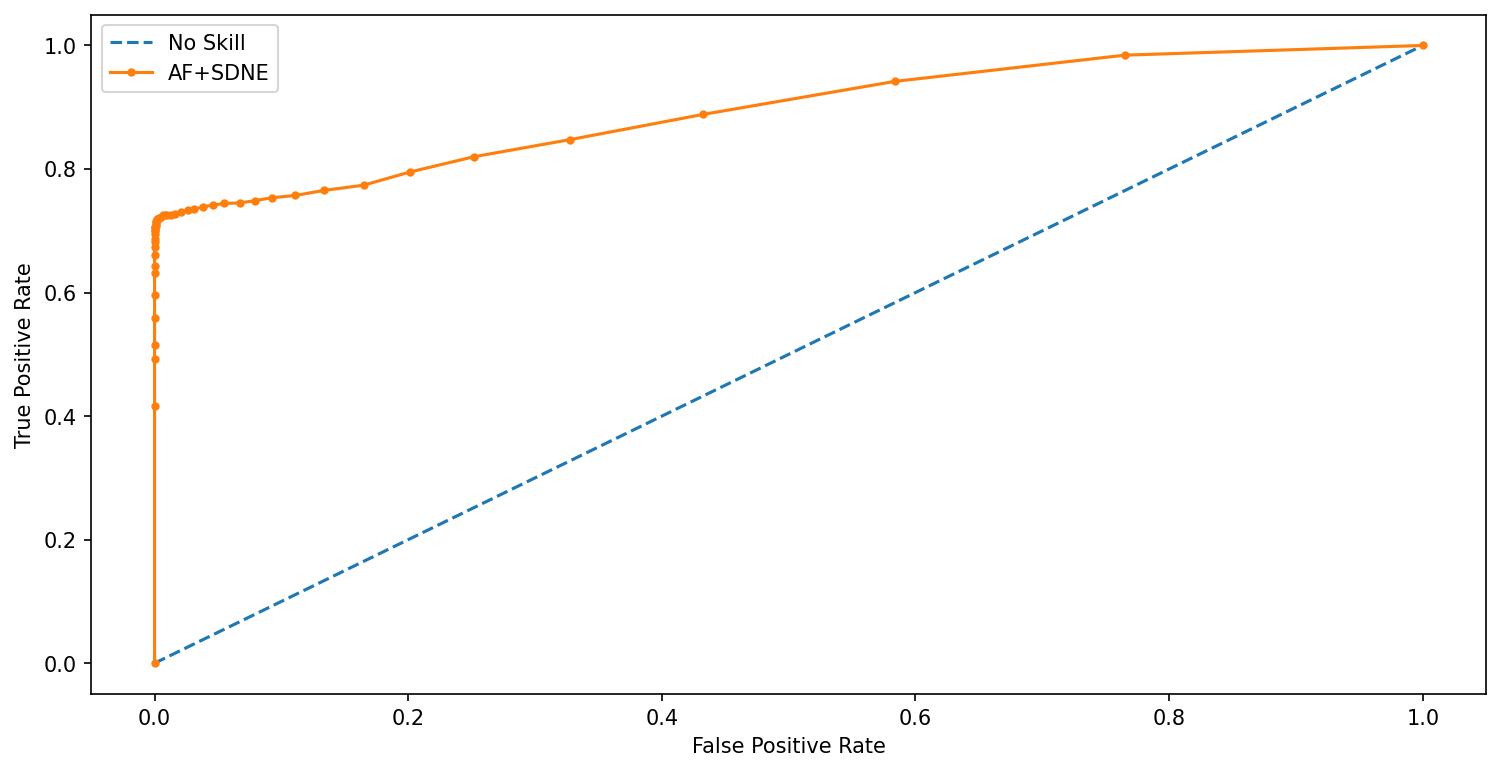

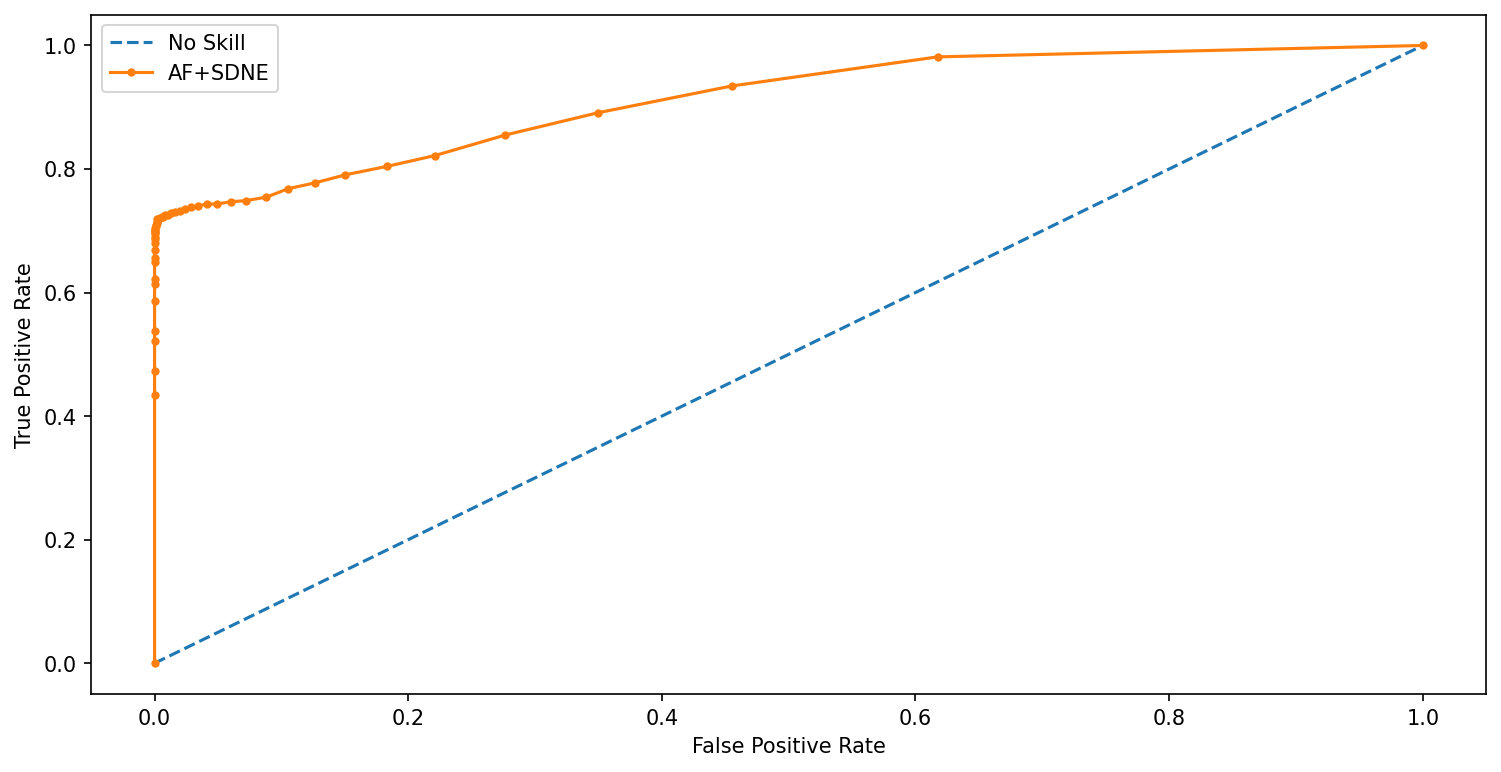

In [27]:
fpr1, tpr1=draw_roc(1)
fpr2, tpr2=draw_roc(2)

In [28]:
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

0.893 0.911


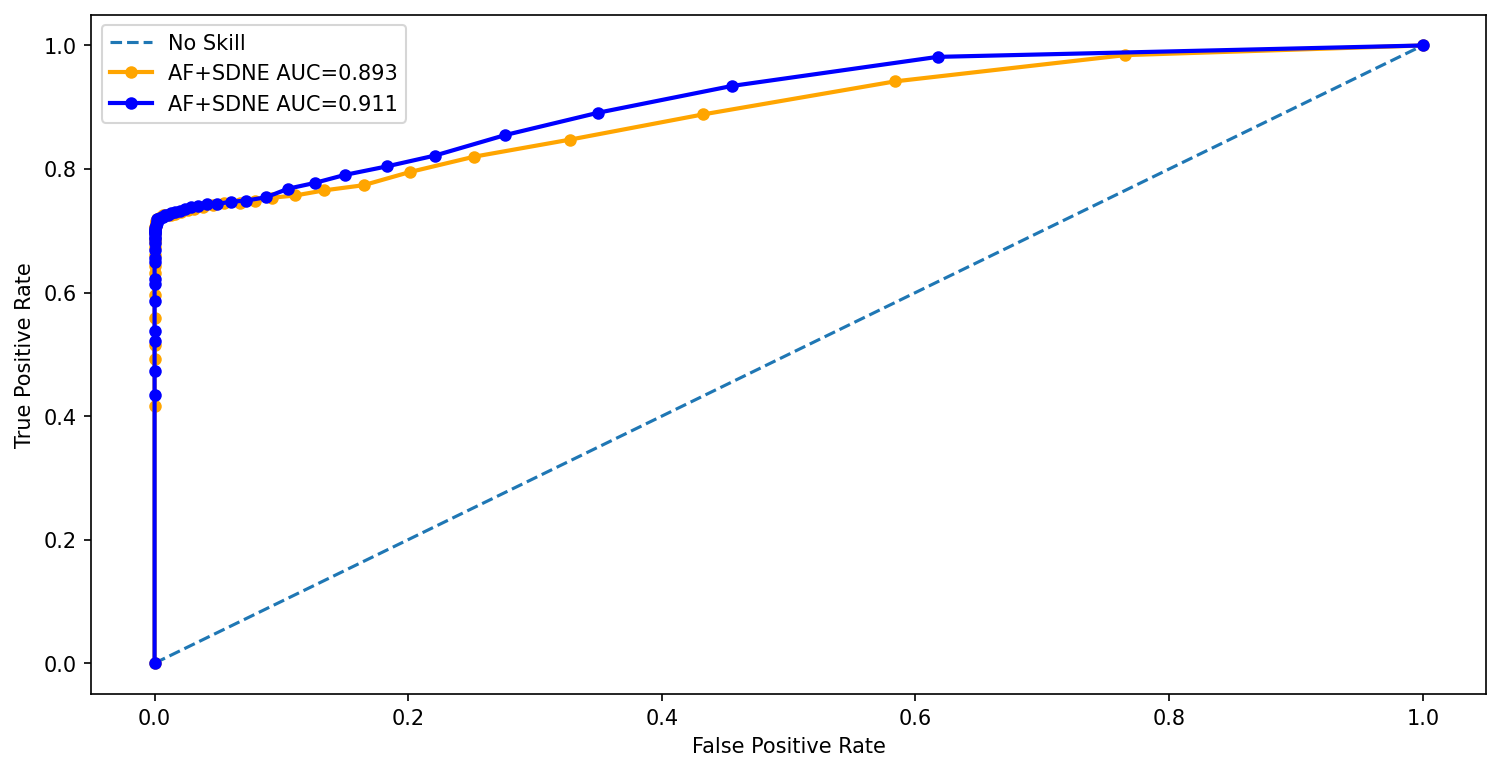

In [30]:
plt.figure(figsize=(12, 6), dpi=150)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
print(round(roc_auc1,3),round(roc_auc2,3))
af_sdne = plt.plot(fpr1, tpr1, "r", marker='.', c='orange', ms=10, linewidth='2',  label="AF+SDNE AUC={}".format(round(roc_auc1,3)))
af_dsdne = plt.plot(fpr2, tpr2, "r", marker='.', c='blue', ms=10, linewidth='2',  label="AF+SDNE AUC={}".format(round(roc_auc2,3)))

plt.legend(labels = ["AF illicit F1","AF+SDNE illicit F1","AF+DSDNE illicit F1"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig("ROC.png")